
# L1-based models for Sparse Signals

The present example compares three l1-based regression models on a synthetic
signal obtained from sparse and correlated features that are further corrupted
with additive gaussian noise:

 - a `lasso`;
 - an `automatic_relevance_determination`;
 - an `elastic_net`.

It is known that the Lasso estimates turn to be close to the model selection
estimates when the data dimensions grow, given that the irrelevant variables are
not too correlated with the relevant ones. In the presence of correlated
features, Lasso itself cannot select the correct sparsity pattern [1]_.

Here we compare the performance of the three models in terms of the $R^2$
score, the fitting time and the sparsity of the estimated coefficients when
compared with the ground-truth.


In [ ]:
# Author: Arturo Amor <david-arturo.amor-quiroz@inria.fr>

## Generate synthetic dataset

We generate a dataset where the number of samples is lower than the total
number of features. This leads to an underdetermined system, i.e. the solution
is not unique, and thus we cannot apply an `ordinary_least_squares` by
itself. Regularization introduces a penalty term to the objective function,
which modifies the optimization problem and can help alleviate the
underdetermined nature of the system.

The target `y` is a linear combination with alternating signs of sinusoidal
signals. Only the 10 lowest out of the 100 frequencies in `X` are used to
generate `y`, while the rest of the features are not informative. This results
in a high dimensional sparse feature space, where some degree of
l1-penalization is necessary.



In [1]:
import numpy as np

rng = np.random.RandomState(0)
n_samples, n_features, n_informative = 50, 100, 10
time_step = np.linspace(-2, 2, n_samples)
freqs = 2 * np.pi * np.sort(rng.rand(n_features)) / 0.01
X = np.zeros((n_samples, n_features))

for i in range(n_features):
    X[:, i] = np.sin(freqs[i] * time_step)

idx = np.arange(n_features)
true_coef = (-1) ** idx * np.exp(-idx / 10)
true_coef[n_informative:] = 0  # sparsify coef
y = np.dot(X, true_coef)

Some of the informative features have close frequencies to induce
(anti-)correlations.



In [2]:
freqs[:n_informative]

array([ 2.9502547 , 11.8059798 , 12.63394388, 12.70359377, 24.62241605,
       37.84077985, 40.30506066, 44.63327171, 54.74495357, 59.02456369])

A random phase is introduced using :func:`numpy.random.random_sample`
and some gaussian noise (implemented by :func:`numpy.random.normal`)
is added to both the features and the target.



In [3]:
for i in range(n_features):
    X[:, i] = np.sin(freqs[i] * time_step + 2 * (rng.random_sample() - 0.5))
    X[:, i] += 0.2 * rng.normal(0, 1, n_samples)

y += 0.2 * rng.normal(0, 1, n_samples)

Such sparse, noisy and correlated features can be obtained, for instance, from
sensor nodes monitoring some environmental variables, as they typically register
similar values depending on their positions (spatial correlations).
We can visualize the target.



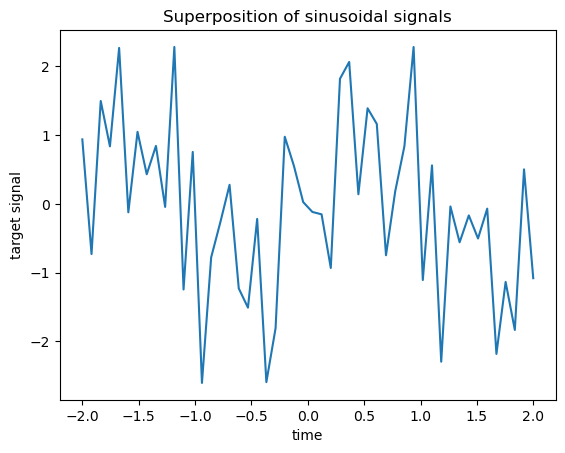

In [4]:
import matplotlib.pyplot as plt

plt.plot(time_step, y)
plt.ylabel("target signal")
plt.xlabel("time")
_ = plt.title("Superposition of sinusoidal signals")

We split the data into train and test sets for simplicity. In practice one
should use a :class:`~sklearn.model_selection.TimeSeriesSplit`
cross-validation to estimate the variance of the test score. Here we set
`shuffle="False"` as we must not use training data that succeed the testing
data when dealing with data that have a temporal relationship.



In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

In the following, we compute the performance of three l1-based models in terms
of the goodness of fit $R^2$ score and the fitting time. Then we make a
plot to compare the sparsity of the estimated coefficients with respect to the
ground-truth coefficients and finally we analyze the previous results.

## Lasso

In this example, we demo a :class:`~sklearn.linear_model.Lasso` with a fixed
value of the regularization parameter `alpha`. In practice, the optimal
parameter `alpha` should be selected by passing a
:class:`~sklearn.model_selection.TimeSeriesSplit` cross-validation strategy to a
:class:`~sklearn.linear_model.LassoCV`. To keep the example simple and fast to
execute, we directly set the optimal value for alpha here.



In [6]:
from time import time

from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

t0 = time()
lasso = Lasso(alpha=0.14).fit(X_train, y_train)
print(f"Lasso fit done in {(time() - t0):.3f}s")

y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso r^2 on test data : {r2_score_lasso:.3f}")

Lasso fit done in 0.001s
Lasso r^2 on test data : 0.480


## Automatic Relevance Determination (ARD)

An ARD regression is the bayesian version of the Lasso. It can produce
interval estimates for all of the parameters, including the error variance, if
required. It is a suitable option when the signals have gaussian noise. See
the example `sphx_glr_auto_examples_linear_model_plot_ard.py` for a
comparison of :class:`~sklearn.linear_model.ARDRegression` and
:class:`~sklearn.linear_model.BayesianRidge` regressors.



In [7]:
from sklearn.linear_model import ARDRegression

t0 = time()
ard = ARDRegression().fit(X_train, y_train)
print(f"ARD fit done in {(time() - t0):.3f}s")

y_pred_ard = ard.predict(X_test)
r2_score_ard = r2_score(y_test, y_pred_ard)
print(f"ARD r^2 on test data : {r2_score_ard:.3f}")

ARD fit done in 0.129s
ARD r^2 on test data : 0.543


## ElasticNet

:class:`~sklearn.linear_model.ElasticNet` is a middle ground between
:class:`~sklearn.linear_model.Lasso` and :class:`~sklearn.linear_model.Ridge`,
as it combines a L1 and a L2-penalty. The amount of regularization is
controlled by the two hyperparameters `l1_ratio` and `alpha`. For `l1_ratio =
0` the penalty is pure L2 and the model is equivalent to a
:class:`~sklearn.linear_model.Ridge`. Similarly, `l1_ratio = 1` is a pure L1
penalty and the model is equivalent to a :class:`~sklearn.linear_model.Lasso`.
For `0 < l1_ratio < 1`, the penalty is a combination of L1 and L2.

As done before, we train the model with fix values for `alpha` and `l1_ratio`.
To select their optimal value we used an
:class:`~sklearn.linear_model.ElasticNetCV`, not shown here to keep the
example simple.



In [9]:
from sklearn.linear_model import ElasticNet

t0 = time()
enet = ElasticNet(alpha=0.08, l1_ratio=0.5).fit(X_train, y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(f"ElasticNet r^2 on test data : {r2_score_enet:.3f}")

ElasticNet fit done in 0.003s
ElasticNet r^2 on test data : 0.636


## Plot and analysis of the results

In this section, we use a heatmap to visualize the sparsity of the true
and estimated coefficients of the respective linear models.



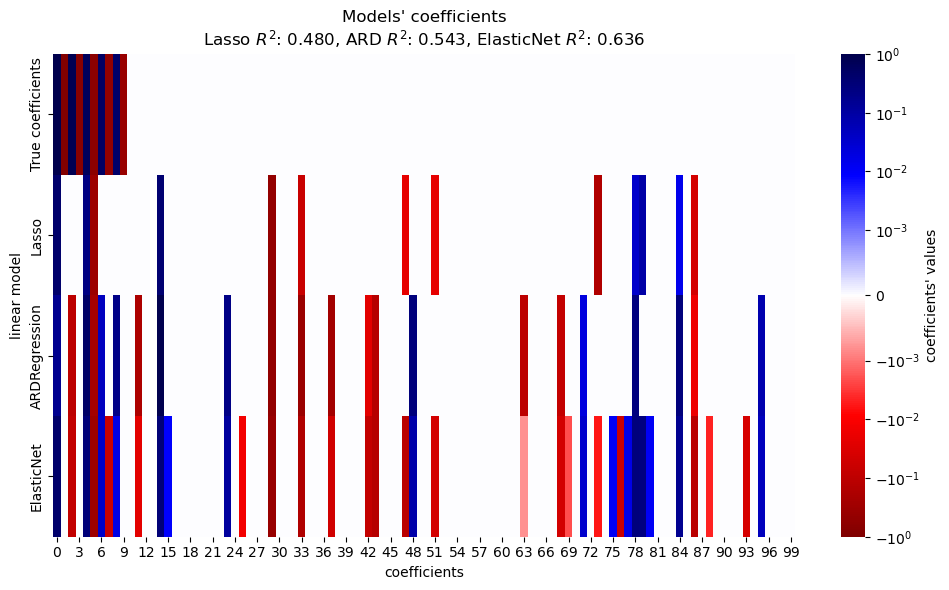

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import SymLogNorm

df = pd.DataFrame(
    {
        "True coefficients": true_coef,
        "Lasso": lasso.coef_,
        "ARDRegression": ard.coef_,
        "ElasticNet": enet.coef_,
    }
)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-1, vmax=1),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)
plt.ylabel("linear model")
plt.xlabel("coefficients")
plt.title(
    f"Models' coefficients\nLasso $R^2$: {r2_score_lasso:.3f}, "
    f"ARD $R^2$: {r2_score_ard:.3f}, "
    f"ElasticNet $R^2$: {r2_score_enet:.3f}"
)
plt.tight_layout()

In the present example `ElasticNet` yields the
best score and captures the most of the predictive features, yet still fails
at finding all the true components. Notice that both
`ElasticNet` and
`ARDRegression` result in a less sparse model
than a `Lasso`.

## Conclusions

`Lasso` is known to recover sparse data
effectively but does not perform well with highly correlated features. Indeed,
if several correlated features contribute to the target,
`Lasso` would end up selecting a single one of
them. In the case of sparse yet non-correlated features, a
`Lasso` model would be more suitable.

`ElasticNet` introduces some sparsity on the
coefficients and shrinks their values to zero. Thus, in the presence of
correlated features that contribute to the target, the model is still able to
reduce their weights without setting them exactly to zero. This results in a
less sparse model than a pure `Lasso` and may
capture non-predictive features as well.

`ARDRegression` is better when handling gaussian
noise, but is still unable to handle correlated features and requires a larger
amount of time due to fitting a prior.

## References

  .. [1] `"Lasso-type recovery of sparse representations for
   high-dimensional data" N. Meinshausen, B. Yu - The Annals of Statistics
   2009, Vol. 37, No. 1, 246-270 <10.1214/07-AOS582>`

